In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.utils.data
import numpy as np
import sklearn.datasets
import sklearn.model_selection
import matplotlib.pyplot as plt

import abstract_gradient_training as agt

In [2]:
"""Initialise the halfmoons training data."""
seed = 0
batchsize = 10000  # number of samples per batch
test_size = 5000
n_users = 100
n_batches = 1  # number of batches per epoch
n_epochs = 10  # number of epochs

torch.manual_seed(seed)
# load the dataset
x, y = sklearn.datasets.make_moons(noise=0.1, n_samples=n_batches*batchsize + test_size, random_state=seed)
# to make it easier to train, we'll space the moons out a bit and add some polynomial features
x[y==0, 1] += 0.2
x = np.hstack((x, x**2, (x[:, 0] * x[:, 1])[:, None], x**3))


# Train-test split
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    x, y, test_size=test_size / (n_batches * batchsize + test_size), random_state=seed
)


# Assign users randomly to each set after the split
user_train = np.random.randint(1, n_users + 1, size=len(x_train))
user_test = np.random.randint(1, n_users + 1, size=len(x_test))

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
x_test = torch.from_numpy(x_test).float()
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)
user_train = torch.from_numpy(user_train)
user_test = torch.from_numpy(user_test)

# Combine inputs and both labels into TensorDatasets
dataset_train = torch.utils.data.TensorDataset(x_train, user_train, y_train)
dataset_test = torch.utils.data.TensorDataset(x_test, user_test, y_test)

print(y)

# Create DataLoaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batchsize, shuffle=False)



[0 1 1 ... 1 1 0]


In [ ]:
import importlib
importlib.reload(agt)
"""Let's train a logistic classifier on the halfmoons example above."""
# model = torch.nn.Sequential(torch.nn.Linear(7, 2))
torch.manual_seed(1)
model = torch.nn.Sequential(
    torch.nn.Linear(7, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 2),
)
config = agt.AGTConfig(
    fragsize=2000,
    learning_rate=0.5,
    n_epochs=n_epochs,
    device="cuda:0",
    l2_reg=0.01,
    k_private=1,
    loss="cross_entropy",
    log_level="INFO",
    lr_decay=2.0,
    clip_gamma=1.0,
    lr_min=0.001,
    optimizer="SGDM", # we'll use SGD with momentum
    optimizer_kwargs={"momentum": 0.9, "nesterov": True},
)
k_values = [1,2,5,10,20,50,100]  # using more values here will improve the guarantees AGT will give
# k_values = [0]  # using more values here will improve the guarantees AGT will give
bounded_model_dict = {}  # we'll store our results for each value of 'k' as a dictionary from 'k' to the bounded model

for k_private in k_values:
    config.k_private=k_private
    torch.manual_seed(seed)
    bounded_model = agt.bounded_models.IntervalBoundedModel(model)
    bounded_model = agt.privacy_certified_training_user_level(bounded_model, config, dataloader_train, dataloader_test)
    bounded_model_dict[k_private] = bounded_model
    
    # as a metric, compute the number of predictions in the test set certified at this value of k_private
    certified_preds = agt.test_metrics.certified_predictions(bounded_model, x_test)

[AGT] [INFO    ] [08:29:45] =================== Starting Privacy Certified Training ===================
[AGT] [INFO    ] [08:29:45] k=0 suffers from numerical instability in the bounds, consider using k > 0 or dtype double.
[AGT] [INFO    ] [08:29:45] Starting epoch 1
[AGT] [INFO    ] [08:29:45] Batch 1. Loss (accuracy): 0.514 <= 0.514 <= 0.514
[AGT] [INFO    ] [08:29:56] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [08:29:56] Starting epoch 2
[AGT] [INFO    ] [08:29:56] Batch 2. Loss (accuracy): 0.514 <= 0.514 <= 0.514
[AGT] [INFO    ] [08:30:06] Starting epoch 3
[AGT] [INFO    ] [08:30:07] Batch 3. Loss (accuracy): 0.514 <= 0.514 <= 0.514
[AGT] [INFO    ] [08:30:17] Starting epoch 4
[AGT] [INFO    ] [08:30:17] Batch 4. Loss (accuracy): 0.514 <= 0.514 <= 0.514
[AGT] [INFO    ] [08:30:27] Starting epoch 5
[AGT] [INFO    ] [08:30:27] Batch 5. Loss (accuracy): 0.523 <= 0.523 <= 0.523
[AGT] [INFO    ] [08:30:38] Starting epoch

In [4]:
"""Let's use this set of bounded models to for better private prediction using the smooth sensitivity mechanism."""

epsilon = 0.2  # privacy loss
noise_free_acc = agt.test_metrics.test_accuracy(bounded_model_dict[1], x_test, y_test)[0]

# compute accuracy using the smooth sensitivity Cauchy mechanism
smooth_sens_noise_level = agt.privacy_utils.get_calibrated_noise_level(
    x_test, bounded_model_dict, epsilon, noise_type="cauchy"
)
smooth_sens_acc = agt.privacy_utils.noisy_test_accuracy(
    bounded_model_dict[1], x_test, y_test, noise_level=smooth_sens_noise_level, noise_type="cauchy"
)


# compute accuracy when using the global sensitivity mechanism
global_sens_acc = agt.privacy_utils.noisy_test_accuracy(
    bounded_model_dict[1], x_test, y_test, noise_level=1.0 / epsilon
)

print(f"Noise Free Accuracy: {noise_free_acc:.2f}")
print(f"Smooth Sensitivity Accuracy: {smooth_sens_acc:.2f}")
print(f"Global Sensitivity Accuracy: {global_sens_acc:.2f}")

KeyError: 1

In [ ]:
for k in [1,2,5,10,20,50,100]:
# for k in [0]:
    bounded_model_dict[k].save_params(f"model_user_10000/100/k_{k}.model")

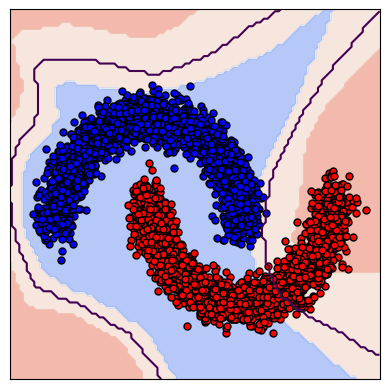

In [ ]:
"""Plot the moons, the decision boundary, and the certified region"""
fig, ax = plt.subplots()
ax.set_box_aspect(1)
ax.set_xticks([])
ax.set_yticks([])
gridsize = 100

bounded_model = bounded_model_dict[2]

# define a grid of points and add features
x0 = torch.linspace(-1.5, 2.5, gridsize)
x1 = torch.linspace(-1.2, 2.2, gridsize)
X0, X1 = torch.meshgrid(x0, x1)
X0f, X1f = X0.flatten(), X1.flatten()
grid_data = torch.stack((X0f, X1f, X0f**2, X1f**2, X0f * X1f, X0f ** 3, X1f ** 3), dim=1)
grid_data = grid_data.to(bounded_model.device)

# compute the predictions of the model over the grid and plot the decision boundary
logits = bounded_model.forward(grid_data)
preds = logits.argmax(dim=1).reshape(gridsize, gridsize).cpu().numpy()
ax.contour(X0, X1, preds, levels=[0.5])

# compute the certified regions
logits_l, logits_u = bounded_model.bound_forward(grid_data, grid_data)
cert_preds_0 = (logits_l[:, 0] >= logits_u[:, 1]).float()  # where the model always predicts class 0
cert_preds_1 = (logits_l[:, 1] >= logits_u[:, 0]).float()  # where the model always predicts class 1
cert_preds = (cert_preds_0 - cert_preds_1).reshape(gridsize, gridsize).cpu().numpy()
ax.contourf(X0, X1, cert_preds, cmap="coolwarm_r", levels=[-1.5, -0.5, 0.0, 0.5, 1.5], alpha=0.5)

# plot the moons
ax.scatter(x_test[y_test == 0, 0], x_test[y_test == 0, 1], s=25, edgecolors="k", color="blue")
ax.scatter(x_test[y_test == 1, 0], x_test[y_test == 1, 1], s=25, edgecolors="k", color="red")